## Amazon movie reviews analysis
Using spark for pre-processing

In [1]:
import pyspark as ps    # for the pyspark suite
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('moviemood')
         .getOrCreate()
        )

In [2]:
data_path = '../../datasets/'
file_name = 'reviews_Movies_and_TV.json.gz'

In [3]:
amazon_reviews_df = spark.read.json(data_path + file_name)

In [4]:
amazon_reviews_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [5]:
# Took 2 minutes
amazon_reviews_df.cache()
total_comment_count = amazon_reviews_df.count()

In [6]:
total_comment_count

4607047

In [ ]:
# Interrupted after 1 hour
# all_reviews_df = amazon_reviews_df.toPandas()

In [ ]:
movie_groups = all_reviews_df.groupby('asin')
movies_lots_comments = movie_groups.filter(lambda x: x['asin'].count() >= 10)

In [ ]:
movies_lots_comments_count = len(movies_lots_comments.index)
movies_lots_comments_count

In [ ]:
movies_lots_comments.to_pickle('../../datasets/reviews_Movies_and_TV_10_reviews.pkl.gz')

## Data sampling for development

In [5]:
dev_sample_fraction = 0.001

In [6]:
reviews_spark_df = amazon_reviews_df.sample(withReplacement=False, fraction=dev_sample_fraction)

In [7]:
reviews_df = reviews_spark_df.toPandas()

In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4519 entries, 0 to 4518
Data columns (total 9 columns):
asin              4519 non-null object
helpful           4519 non-null object
overall           4519 non-null float64
reviewText        4519 non-null object
reviewTime        4519 non-null object
reviewerID        4519 non-null object
reviewerName      4502 non-null object
summary           4519 non-null object
unixReviewTime    4519 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 317.8+ KB


In [298]:
reviews_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0005019281,"[0, 0]",4.0,Winkler does a little over-the-top in his role as the scrooge character and the production values leave somewhat more to be desired but all-in-all a nice rendition for holiday viewing.,"01 6, 2014",A22GJ2SRENMZS0,"F. Sisti ""ftt meditator""",Dated TV Flic,1388966400
1,0005019281,"[0, 0]",3.0,Nice rendition on classic movie. Henry Winkler does a good job of playing a Scrooge type character. Worth seeing this time of year.,"12 11, 2013",A6RVT4SPVTVSF,Richard Beckler,Worth a view.,1386720000
2,0005119367,"[0, 0]",5.0,Its so hard to find movies that the whole family can watch. This movie projects positive values with an engaging story. The acting was very believeable and top notch.,"05 9, 2013",ASNYRY8236Z2V,minafox,1st Rate!,1368057600
3,0307514161,"[4, 8]",5.0,This is probably the best of the Christmas cartoons. It never grows old and should be a Christmas tradition for everyone.,"12 14, 2007",A1EM0LBNBVUQ4U,Rocky Sullivan,A classic!,1197590400
4,0307514161,"[0, 0]",5.0,They loved it and it helped Mom get ready for Christmas. We watch it every year and I wanted them to have their own DVD.,"12 29, 2012",A2EUFJ0KZP8GFH,sara b layton,A gift for the great grandkids,1356739200


### Filter out comments that may be relative to the support (DVD, edition...)

In [299]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

words_to_remove = ['dvd', 'vhs','edition', 'blue-ray', 'blueray', 'blu-ray', 'bluray', 'price']

In [300]:
words_to_remove_re = '(' + '|'.join(words_to_remove) + ')'

In [301]:
import warnings
warnings.simplefilter('ignore')
text_removed = reviews_df[reviews_df['reviewText'].str.contains(words_to_remove_re, case=False)]
warnings.simplefilter('default')

In [302]:
text_removed.describe()

,overall,unixReviewTime
count,1105.000000,1.105000e+03
mean,4.199095,1.256431e+09
std,1.256937,1.190564e+08
min,1.000000,9.359712e+08
25%,4.000000,1.176509e+09
50%,5.000000,1.281312e+09
75%,5.000000,1.359072e+09
max,5.000000,1.405728e+09


#### Result: fraction of content removed:

In [303]:
len(text_removed.index) / (total_comment_count * dev_sample_fraction)

0.23984995160674502

### For next step: relevant comments = comments w/out words that may be related to the support 

In [304]:
warnings.simplefilter('ignore')
relevant_comments = reviews_df[~reviews_df['reviewText'].str.contains(words_to_remove_re, case=False)]
warnings.simplefilter('default')

## Quality check on filtered data

In [305]:
relevant_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3611 entries, 0 to 4715
Data columns (total 9 columns):
asin              3611 non-null object
helpful           3611 non-null object
overall           3611 non-null float64
reviewText        3611 non-null object
reviewTime        3611 non-null object
reviewerID        3611 non-null object
reviewerName      3593 non-null object
summary           3611 non-null object
unixReviewTime    3611 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 282.1+ KB


In [306]:
relevant_comments['reviewText'].head(2) # try head(50) or more

0    Winkler does a little over-the-top in his role as the scrooge character and the production values leave somewhat more to be desired but all-in-all a nice rendition for holiday viewing.
1    Nice rendition on classic movie.  Henry Winkler does a good job of playing a Scrooge type character.  Worth seeing this time of year.                                                   
Name: reviewText, dtype: object

#### Result: reviews look good
Based on quick review of head(50)

## Keyword-based sentiment analysis

#### Dictionary of words tagged with emotions

In [365]:
import csv
global emotions
# emotions = list(emotions_keywords_df)[1:]
# emotion_keywords_csv = 'Andbrain_DataSet.csv'
emotion_keywords_csv = 'andbrainDataSet108.csv'
emotions_keywords = {}
emotions2 = []
with open(emotion_keywords_path + emotion_keywords_csv, mode='r', errors='replace') as csvfile:
    reader = csv.reader(csvfile, dialect='excel')
    emotions2 = reader.__next__()  # skip headers
#     print (emotions2)
    for row in reader:
#         print(row)
        dico = {}
        for i in range(1,8):
            dico[emotions2[i].strip()] = float(row[i])
        emotions_keywords[row[0].strip()] = dico

global emotions
emotions = emotions2[1:]
emotions

['disgust', 'surprise', 'neutral', 'anger', 'sad', 'happy', 'fear']

### Number of words in emotions dictionary

In [366]:
key_count = 0
for key in emotions_keywords.keys():
    key_count += 1
key_count

23729

In [367]:
rel_comments_w_sentiments = relevant_comments.reindex(columns= relevant_comments.columns.tolist() + emotions)

In [368]:
rel_comments_w_sentiments.head(1)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,disgust,surprise,neutral,anger,sad,happy,fear
0,0005019281,"[0, 0]",4.0,Winkler does a little over-the-top in his role as the scrooge character and the production values leave somewhat more to be desired but all-in-all a nice rendition for holiday viewing.,"01 6, 2014",A22GJ2SRENMZS0,"F. Sisti ""ftt meditator""",Dated TV Flic,1388966400,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add emotions to comments

In [371]:
def fill_emotions(comment):
    comment_text = comment['reviewText']
    comment_words = comment_text.split(' ')    
    emotion_keywords_hits = 0
    scores = {key: 0.0 for key in emotions}    # {'disgust': 0.0, ...}
    
    for word in comment_words:
        if emotions_keywords.get(word, 0.0) != 0.0:
            for key in scores.keys():
                scores[key] += emotions_keywords[word][key]
            
    for emotion in emotions:
        comment[emotion] = scores[emotion]
    return comment

rel_comments_w_emotions = rel_comments_w_sentiments.apply(fill_emotions, axis=1, raw=True)

#### Test: validating fear detection

In [373]:
test_comment = {key: float('nan') for key in emotions}
test_comment['reviewText'] = 'This is scary movie I ending'
fill_emotions(test_comment)

{'disgust': 0.0368733986813,
 'surprise': 0.1221268629813,
 'neutral': 0.0396885911,
 'anger': 0.039177546181299996,
 'sad': 0.0414886626225,
 'happy': 0.0530163682645,
 'fear': 0.14056700762250002,
 'reviewText': 'This is scary movie I ending'}

In [374]:
rel_comments_w_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3611 entries, 0 to 4715
Data columns (total 16 columns):
asin              3611 non-null object
helpful           3611 non-null object
overall           3611 non-null float64
reviewText        3611 non-null object
reviewTime        3611 non-null object
reviewerID        3611 non-null object
reviewerName      3593 non-null object
summary           3611 non-null object
unixReviewTime    3611 non-null int64
disgust           3611 non-null float64
surprise          3611 non-null float64
neutral           3611 non-null float64
anger             3611 non-null float64
sad               3611 non-null float64
happy             3611 non-null float64
fear              3611 non-null float64
dtypes: float64(8), int64(1), object(7)
memory usage: 639.6+ KB


In [375]:
rel_comments_w_emotions.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,disgust,surprise,neutral,anger,sad,happy,fear
0,0005019281,"[0, 0]",4.0,Winkler does a little over-the-top in his role as the scrooge character and the production values leave somewhat more to be desired but all-in-all a nice rendition for holiday viewing.,"01 6, 2014",A22GJ2SRENMZS0,"F. Sisti ""ftt meditator""",Dated TV Flic,1388966400,0.081278,0.161821,0.071805,0.271698,0.142592,0.345429,0.163358
1,0005019281,"[0, 0]",3.0,Nice rendition on classic movie. Henry Winkler does a good job of playing a Scrooge type character. Worth seeing this time of year.,"12 11, 2013",A6RVT4SPVTVSF,Richard Beckler,Worth a view.,1386720000,0.054809,0.100859,0.049988,0.083357,0.076816,0.105078,0.152375


## Group reviews by title, remove titles with less than __ reviews

## TODO: revisit before running

In [ ]:
movie_groups = rel_comments_w_emotions.groupby('asin')
movies_lots_comments = movie_groups.filter(lambda x: x['asin'].count() >= 3)

#### Loss from filtering

In [395]:
1 - movies_lots_comments.count()['asin'] / rel_comments_w_emotions.count()['asin']

0.8814732761008031

## Remove reviews with no emotions

In [ ]:
movies_lots_emotions = movies_lots_comments[( \
                             movies_lots_comments['disgust'] + \
                             movies_lots_comments['surprise'] + \
                             movies_lots_comments['neutral'] + \
                             movies_lots_comments['anger'] + \
                             movies_lots_comments['sad'] + \
                             movies_lots_comments['happy'] + \
                             movies_lots_comments['fear']) > 0]

In [ ]:
len(movies_lots_emotions.index)

## Basic emotions analysis - Not sure the correlation is correct

In [376]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

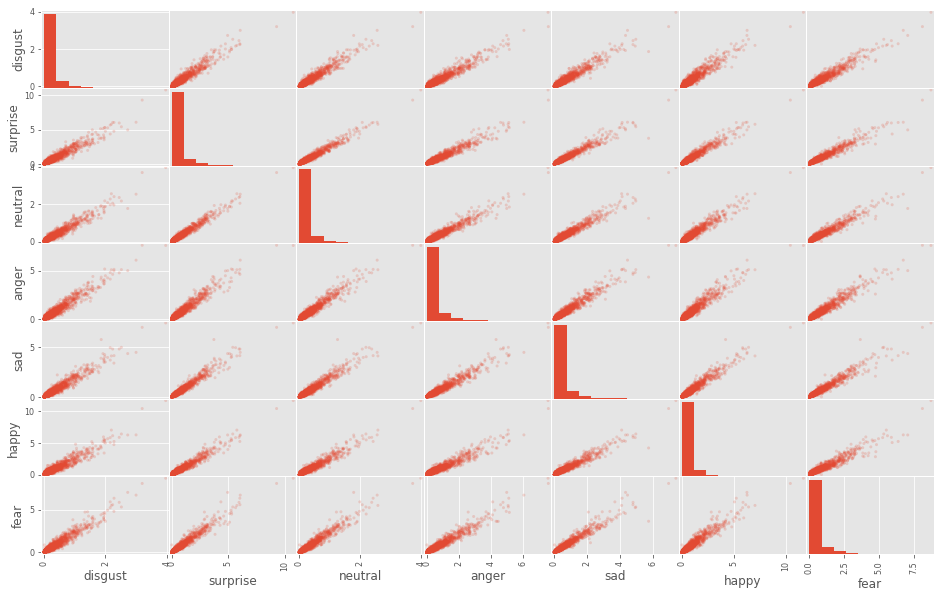

In [377]:
pd.plotting.scatter_matrix(rel_comments_w_emotions[['disgust', 'surprise','neutral','anger','sad','happy','fear']], alpha=0.2, figsize=(16, 10))
plt.show()

## Sentiment coherence in comments
### Surprising
Happy is very correlated to all sentiments (except neutral), in particularly anger, sad and fear
### Not surprising
Neutral is weakly connected to other sentiments

In [378]:
rel_comments_w_emotions[['disgust', 'surprise','neutral','anger','sad','happy','fear']].corr()

,disgust,surprise,neutral,anger,sad,happy,fear
disgust,1.000000,0.961566,0.965700,0.965772,0.964458,0.949543,0.965478
surprise,0.961566,1.000000,0.977672,0.967219,0.972703,0.968520,0.970078
neutral,0.965700,0.977672,1.000000,0.967201,0.967305,0.963038,0.968875
anger,0.965772,0.967219,0.967201,1.000000,0.970706,0.956637,0.969320
sad,0.964458,0.972703,0.967305,0.970706,1.000000,0.965233,0.970717
happy,0.949543,0.968520,0.963038,0.956637,0.965233,1.000000,0.959127
fear,0.965478,0.970078,0.968875,0.969320,0.970717,0.959127,1.000000


In [326]:
rel_comments_w_emotions[['disgust','fear']].head(1)

,disgust,fear
0,0.011589,0.0839


## Isolating Comment helpfulness

In [24]:
helpful = reviews_df['helpful'].map(lambda x: x[0], na_action='ignore')
helpful.describe()

count    91869.000000
mean     2.638866    
std      11.521295   
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      2.000000    
max      1031.000000 
Name: helpful, dtype: float64

In [25]:
not_helpful = reviews_df['helpful'].map(lambda x: x[1], na_action='ignore')
not_helpful.describe()

count    91869.000000
mean     4.093655    
std      14.126499   
min      0.000000    
25%      0.000000    
50%      1.000000    
75%      4.000000    
max      1160.000000 
Name: helpful, dtype: float64

### Note: current filtering is probably too aggressive:'DVD' mostly used to describe the movie
Removing DVD would remove a lot of good comments, as all of the following are appropriate:

In [26]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
text_removed['reviewText'].head(5)

11    I have watched this version of &#34;Joseph&#34; numerous times also on TV and am once again glad to add this one to my collection of Bible DVD's. It's entertainment but for me it's much than that I'm able to receive a better understanding of my Bible it's like a learning process to test me on my Bible knowledge and see how well I know the scriptures, for instance when I'm able to pick something out of the movie that may not be quite true to scripture I go check my Bible and I'm able to learn my scriptures better and my Bible. I believe by watching the DVD over and over and even having different versions you absorb more into your memory and it can be your own individual Bible study. I was really amazed and excited when I saw that you offered many of these DVD's of (The Bible Collection) which are some of my favorites. Hoping to collect them all and other versions plus other Christian DVD's to learn from them for a better understanding of God's true Word.
13    I use the Hemisphere

In [28]:
text_removed = reviews_df[(reviews_df['reviewText'].str.contains('(dvd|vhs)', case=False)) & (helpful > 1)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [29]:
text_removed[['reviewText','helpful']].head(5)

,reviewText,helpful
30,"What with Meryl Streep portraying her in a movie and all, Julia's books and series are getting a monster tidal wave of fresh attention. I wonder how many youngsters (Food Network viewers) will purchase or have purchased for them the classic ""Mastering the Art of French Cooking"" and find it completely overwhelming and not necessarily useful for everyday cooking?I had few cooking skills in the mid 1980s when this book and DVD came out, and I relied on recipes from Fannie Farmer, supermarket recipe cards, and women's magazines. This series elevated my cooking for good. It is French influenced, but simplified in some cases, and there are variations on most recipes which is really useful if you don't have time to run to the supermarket. I have had many variation cookbooks and this is the best. I have not used the dessert section too much (I prefer Pierre Franey for this--fruit salad with Grand Marnier!), but the bread, meat, and veg sections are the best. I recommend ham steaks with peas and mashed potatoes and cornish game hen broiled w/cheese.I am so pleased this is out on DVD. I gathered up the video tapes one-by-one on ebay and this is definitely more affordable!","[31, 34]"
37,"To start off with, I actually have an early release of the dvd, so my stars are based on that, not the cinema.I made it through about six or seven pages on reviews before I decided to write this and from what I see, three subjects usually appear as the reason for bad reviews.The first reason is it is too violent. We all knew this, before we even went to see it. It was all over news, media, etc. We were warned not to take our kids, be prepared for violence, not for the weak of heart. So, if you went expecting scenes of the beach, then that is your own fault. I didn't watch it hoping to see a blood bath, but I knew it was coming.I am a very faithful Protestant, and I do see some Catholic overtones in the story, but that is Mel's interpretation and overall I felt it was pretty accurate. It is interesting to me that all of these people that may or may not have a personal relationship with Jesus, seem to know that if he were here today, he would not support this film.The second reason people complain is because it doesn't tell the full story of Jesus. It isn't supposed to. It is the Passion of the Christ, and passion means suffering. It isn't the story of the Christ or the Gospel of the Christ. It is basically a Passion play put to cinema. He isn't trying to show us the teachings of Jesus, he is showing us the suffering of Jesus. He is showing us what He went through for us. If you see this movie and aren't moved by the sacrifice that He made for all of us to be free, then you don't get it. And if you don't understand and you don't get it, then that is ok, I pray someday that you will.The third thing I pick up on in these reviews is that Mel is using it just for profit. He has made money at ever other movie he has made I am sure, and yet no one ever questions his motives then. Yet, when he comes out with something of a religious nature when we are in a world that requires us to be politically correct, then he was just doing it for money. He put up his own money and I personally hope he makes all the money he can off of it, not that he needs it. So what if there is a director's cut later on? How may different directors editions or box sets of Lord of the Rings are out there? I get tired of having to apologize for what I believe. If someone stands up for an important issue, whatever the hot topic of the week is, then that is their right to voice their opinion and they expect everyone to recieve it and agree. But if I as a Christian stand up for what I believe, then I am a ""Jesus Freak"" or a ""Fanatic"". So if you don't agree with me, that is your right, but if I don't believe what you do, then I am narrow minded?? What happened to my right to my own beliefs?While I am still on my soap box, it is amazing to me that people still think